In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pyccl as ccl
import numpy as np
from multiprocessing import Pool
import emcee
import matplotlib.pyplot as plt
import time
import healpy as hp
import pickle
import logging
import argparse
def binning(edges): return [[edges[i],edges[i+1]] for i in range(len(edges)-1)]

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_completeness as comp
import model_purity as pur
import model_halo_mass_function as hmf
import class_richness_mass_relation as rm_relation
import model_halo_abundance as cl_count
import model_stacked_cluster_mass as cl_mass
import pinocchio_mass_richness_relation as sim_mr_rel
import class_likelihood as likelihood
import pinocchio_binning_scheme as binning_scheme
import cluster_abundance_covariance as cl_covar

In [3]:
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [4]:
# cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [5]:
clc = cl_count.ClusterAbundance()
CLCovar = cl_covar.Covariance_matrix()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(0.2, 1., 500)
logm_grid = np.linspace(14.3, 15.5, 501)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobiais = halobias_fct)
path_to_mask = "../../data/pinocchio_mask_map_sky_coverage/pinocchio_mask_map_sky_coverage.fits"

In [6]:
Z_bin_standard, logMass_bin_standard = binning_scheme.Z_bin, binning_scheme.LogMass_bin
N_standard = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin_standard, Proxy_bin = logMass_bin_standard, method = 'simps')
NHalo_bias_standard = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin_standard, Proxy_bin = logMass_bin_standard, method = 'simps')
Sij_partialsky_exact_standard = CLCovar.compute_theoretical_Sij(Z_bin_standard, cosmo, clc.f_sky, S_ij_type = 'exact', path = path_to_mask)
Sample_covariance_standard = CLCovar.sample_covariance_full_sky(Z_bin_standard, logMass_bin_standard, NHalo_bias_standard, Sij_partialsky_exact_standard)

In [7]:
Sbb_standard = CLCovar.sample_covariance_full_sky(Z_bin_standard, logMass_bin_standard, NHalo_bias_standard/N_standard, Sij_partialsky_exact_standard)

In [ ]:
logm_edges = np.linspace(14.3, 15.5, 25)
redshift_edges = np.linspace(0.2, 1, 31)
Z_bin_small = binning(redshift_edges)
logMass_bin_small = binning(logm_edges)
N_small = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin_small, Proxy_bin = logMass_bin_small, method = 'simps')
NHalo_bias_small = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin_small, Proxy_bin = logMass_bin_small, method = 'simps')
Sij_partialsky_exact_small = CLCovar.compute_theoretical_Sij(Z_bin_small, cosmo, clc.f_sky, S_ij_type = 'exact', path = path_to_mask)
Sample_covariance_small = CLCovar.sample_covariance_full_sky(Z_bin_small, logMass_bin_small, NHalo_bias_small, Sij_partialsky_exact_small)

In [ ]:
Sbb_small = CLCovar.sample_covariance_full_sky(Z_bin_small, logMass_bin_small, NHalo_bias_small/N_small, Sij_partialsky_exact_small)

# Compute SSC

In [9]:
N_obs_small = np.zeros(N_small.shape,)

In [10]:
Z_bin_small_mat_1 = np.zeros(N_obs_small.shape)
Z_bin_small_mat_0 = np.zeros(N_obs_small.shape)
for i in range(len(logMass_bin_small)):
    Z_bin_small_mat_1[:,i] = np.array(Z_bin_small)[:,1]
    Z_bin_small_mat_0[:,i] = np.array(Z_bin_small)[:,0]
Z_bin_small_mat_1_fllatten = Z_bin_small_mat_1.flatten()
Z_bin_small_mat_0_fllatten = Z_bin_small_mat_0.flatten()

logMass_bin_small_mat_1 = np.zeros(N_obs_small.shape)
logMass_bin_small_mat_0 = np.zeros(N_obs_small.shape)
for i in range(len(Z_bin_small)):
    logMass_bin_small_mat_1[i,:] = np.array(logMass_bin_small)[:,1]
    logMass_bin_small_mat_0[i,:] = np.array(logMass_bin_small)[:,0]
logMass_bin_small_mat_1_fllatten = logMass_bin_small_mat_1.flatten()
logMass_bin_small_mat_0_fllatten = logMass_bin_small_mat_0.flatten()

In [11]:
size=10000
cov_ln1_plus_bdelta_SSC_small = np.log(1 + Sbb_small)
mean_small = -0.5 * cov_ln1_plus_bdelta_SSC_small.diagonal()
rng = np.random.default_rng()
ln1_plus_bdelta_SSC_small_all = rng.multivariate_normal(mean = mean_small , 
                                                          cov = cov_ln1_plus_bdelta_SSC_small , size=size)
ln1_plus_bdelta_SSC_small_all_reshape = [ln1_plus_bdelta_SSC_small_all[k].reshape(len(Z_bin_small), len(logMass_bin_small)) for k in range(size)]

/tmp/ipykernel_25583/720041681.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  ln1_plus_bdelta_SSC_small_all = rng.multivariate_normal(mean = mean_small ,


# Run simulation

In [12]:
def run_simulation(k):
    N_mean_small = N_small
    N_mean_rand_small = N_mean_small * np.exp(ln1_plus_bdelta_SSC_small_all_reshape[k])
    N_obs_small = np.random.poisson(N_mean_rand_small)
    N_obs_small_flatten = N_obs_small.flatten()
    R = np.random.random_sample(size=(2, np.sum(N_obs_small_flatten)))
    redshift, logmass = [], []
    k = 0
    for i in range(len(N_obs_small_flatten)):
        redshift.extend((Z_bin_small_mat_1_fllatten[i] - Z_bin_small_mat_0_fllatten[i]) * R[0, k:k+N_obs_small_flatten[i]] + Z_bin_small_mat_0_fllatten[i])
        logmass.extend((logMass_bin_small_mat_1_fllatten[i] - logMass_bin_small_mat_0_fllatten[i])* R[1, k:k+N_obs_small_flatten[i]]+ logMass_bin_small_mat_0_fllatten[i])
        k = k + N_obs_small_flatten[i]
    N_mass_redshift, a, b = N_mass_redshift, a, b = np.histogram2d(logmass, redshift, bins = [binning_scheme.logm_edges, binning_scheme.redshift_edges, ])
    return N_mass_redshift

In [13]:
%time N_sample = run_simulation(i).T

CPU times: user 24.1 ms, sys: 2.05 ms, total: 26.1 ms
Wall time: 25.5 ms


In [14]:
N_obs_list = []
for i in range(1000):
    #if i%100==0: print(i)
    N_obs_list.append(run_simulation(i))

In [15]:
data = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_data_vector/data_vector_pinocchio_mock_mass-redshift_bins.pkl')

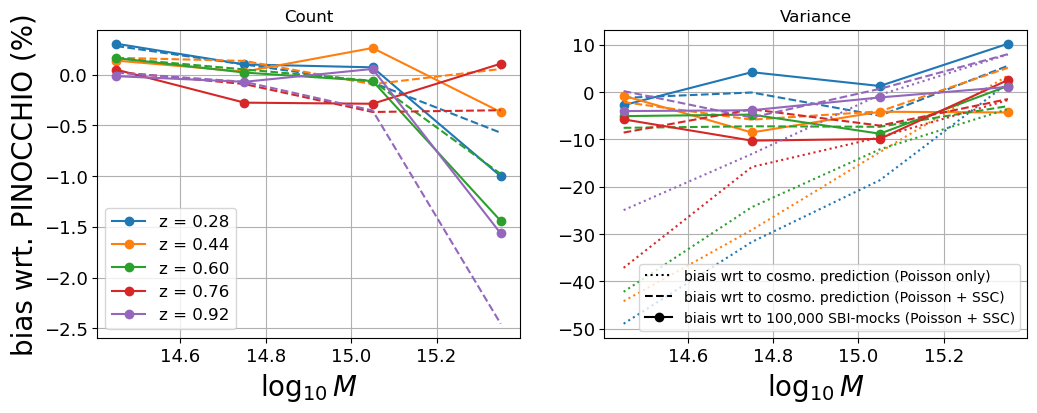

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)

for i in range(len(Z_bin_standard)):
    from_sim = np.mean(np.array(N_obs_list).T[i,:], axis=1)
    from_pred = N_standard[i,:]
    from_pinocchio = data['mean_count_mass_redshift'].T[i,:]
    plt.plot(np.mean(logMass_bin_standard, axis=1), 100*(from_sim-from_pinocchio)/from_pinocchio, '-o'+'C' + str(i), label = 'z = '+f'{np.mean(Z_bin_standard[i]):.2f}')
    plt.plot(np.mean(logMass_bin_standard, axis=1), 100*(from_pred-from_pinocchio)/from_pinocchio, '--' + 'C' + str(i))
plt.title(r'Count')
plt.ylabel('bias wrt. PINOCCHIO (%)', fontsize=20,)
plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.legend(fontsize=12)

plt.subplot(122)
plt.title(r'Variance')
for i in range(len(Z_bin_standard)):
    from_sim = np.std(np.array(N_obs_list).T[i,:], axis=1)**2
    from_pred = N_standard[i,:] + Sample_covariance_standard.diagonal()[i*len(logMass_bin_standard):(i+1)*len(logMass_bin_standard)]
    from_pred_poiss = N_standard[i,:]
    from_pinocchio = (data['err_mean_count_mass_redshift'].T[i,:]**2)
    plt.plot(np.mean(logMass_bin_standard, axis=1), 100*(from_sim-from_pinocchio)/from_pinocchio, '-o'+'C' + str(i))
    plt.plot(np.mean(logMass_bin_standard, axis=1), 100*(from_pred-from_pinocchio)/from_pinocchio, '--' + 'C' + str(i))
    plt.plot(np.mean(logMass_bin_standard, axis=1), 100*(from_pred_poiss-from_pinocchio)/from_pinocchio, ls='dotted' , color= 'C' + str(i))
    
plt.plot([], [], ls='dotted', color='k', label = 'biais wrt to cosmo. prediction (Poisson only)')
plt.plot([], [], '--k', label = 'biais wrt to cosmo. prediction (Poisson + SSC)')
plt.plot([], [], '-ok', label = 'biais wrt to 100,000 SBI-mocks (Poisson + SSC)')
plt.legend()

plt.xlabel(r'$\log_{10}M$', fontsize=20,)
plt.grid(which='both')
plt.tick_params(axis='both', which = 'major', labelsize= 13)